## Top-level Global Var

In [1]:
DEBUG = 9

## Imports

In [2]:
import argparse
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import os
from os.path import dirname
import torch
import torchvision
# from torch.utils.tensorboard import SummaryWriter
import tqdm

if DEBUG>0:
    from utils.models1 import Classifier
else:
    from utils.models import Classifier
from utils.dataset import NCaltech101
from utils.loader import Loader
from utils.train_eval import train_one_epoch, eval_one_epoch

if DEBUG==9:
    torch.manual_seed(4848)
    np.random.seed(4848)

In [3]:
class FLAGS:
    validation_dataset = 'N-Caltech101/validation'
    training_dataset = 'N-Caltech101/training'
    log_dir = 'log/temp'
    device = 'cuda'
    num_workers = 0
    pin_memory = True
    batch_size = 16
    num_epochs = 200
    save_every_n_epochs = 5
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"----------------------------\n"
                  f"Starting training with \n"
                  f"num_epochs: {self.num_epochs}\n"
                  f"batch_size: {self.batch_size}\n"
                  f"device: {self.device}\n"
                  f"log_dir: {self.log_dir}\n"
                  f"training_dataset: {self.training_dataset}\n"
                  f"validation_dataset: {self.validation_dataset}\n"
                  f"num_workers: {self.num_workers}\n"
                  f"pin_memory: {self.pin_memory}\n"
                  f"----------------------------")

In [4]:
flags = FLAGS()

# datasets, add augmentation to training set
training_dataset = NCaltech101(flags.training_dataset, augmentation=True)
validation_dataset = NCaltech101(flags.validation_dataset)

# construct loader, handles data streaming to gpu
training_loader = Loader(training_dataset, flags, device=flags.device)
validation_loader = Loader(validation_dataset, flags, device=flags.device)

# model, and put to device
model = Classifier(device=flags.device)
model = model.to(flags.device)

# optimizer and lr scheduler
optimizerSelect = 'adam'
if optimizerSelect == 'sgd':
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, momentum=0.9, weight_decay=1e-5)
elif optimizerSelect == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)

----------------------------
Starting training with 
num_epochs: 200
batch_size: 16
device: cpu
log_dir: log/temp
training_dataset: N-Caltech101/training
validation_dataset: N-Caltech101/validation
num_workers: 0
pin_memory: True
----------------------------


tensor([47,  5, 23,  5,  3,  3,  3, 47, 31,  0, 94,  3, 44, 34, 15, 64])


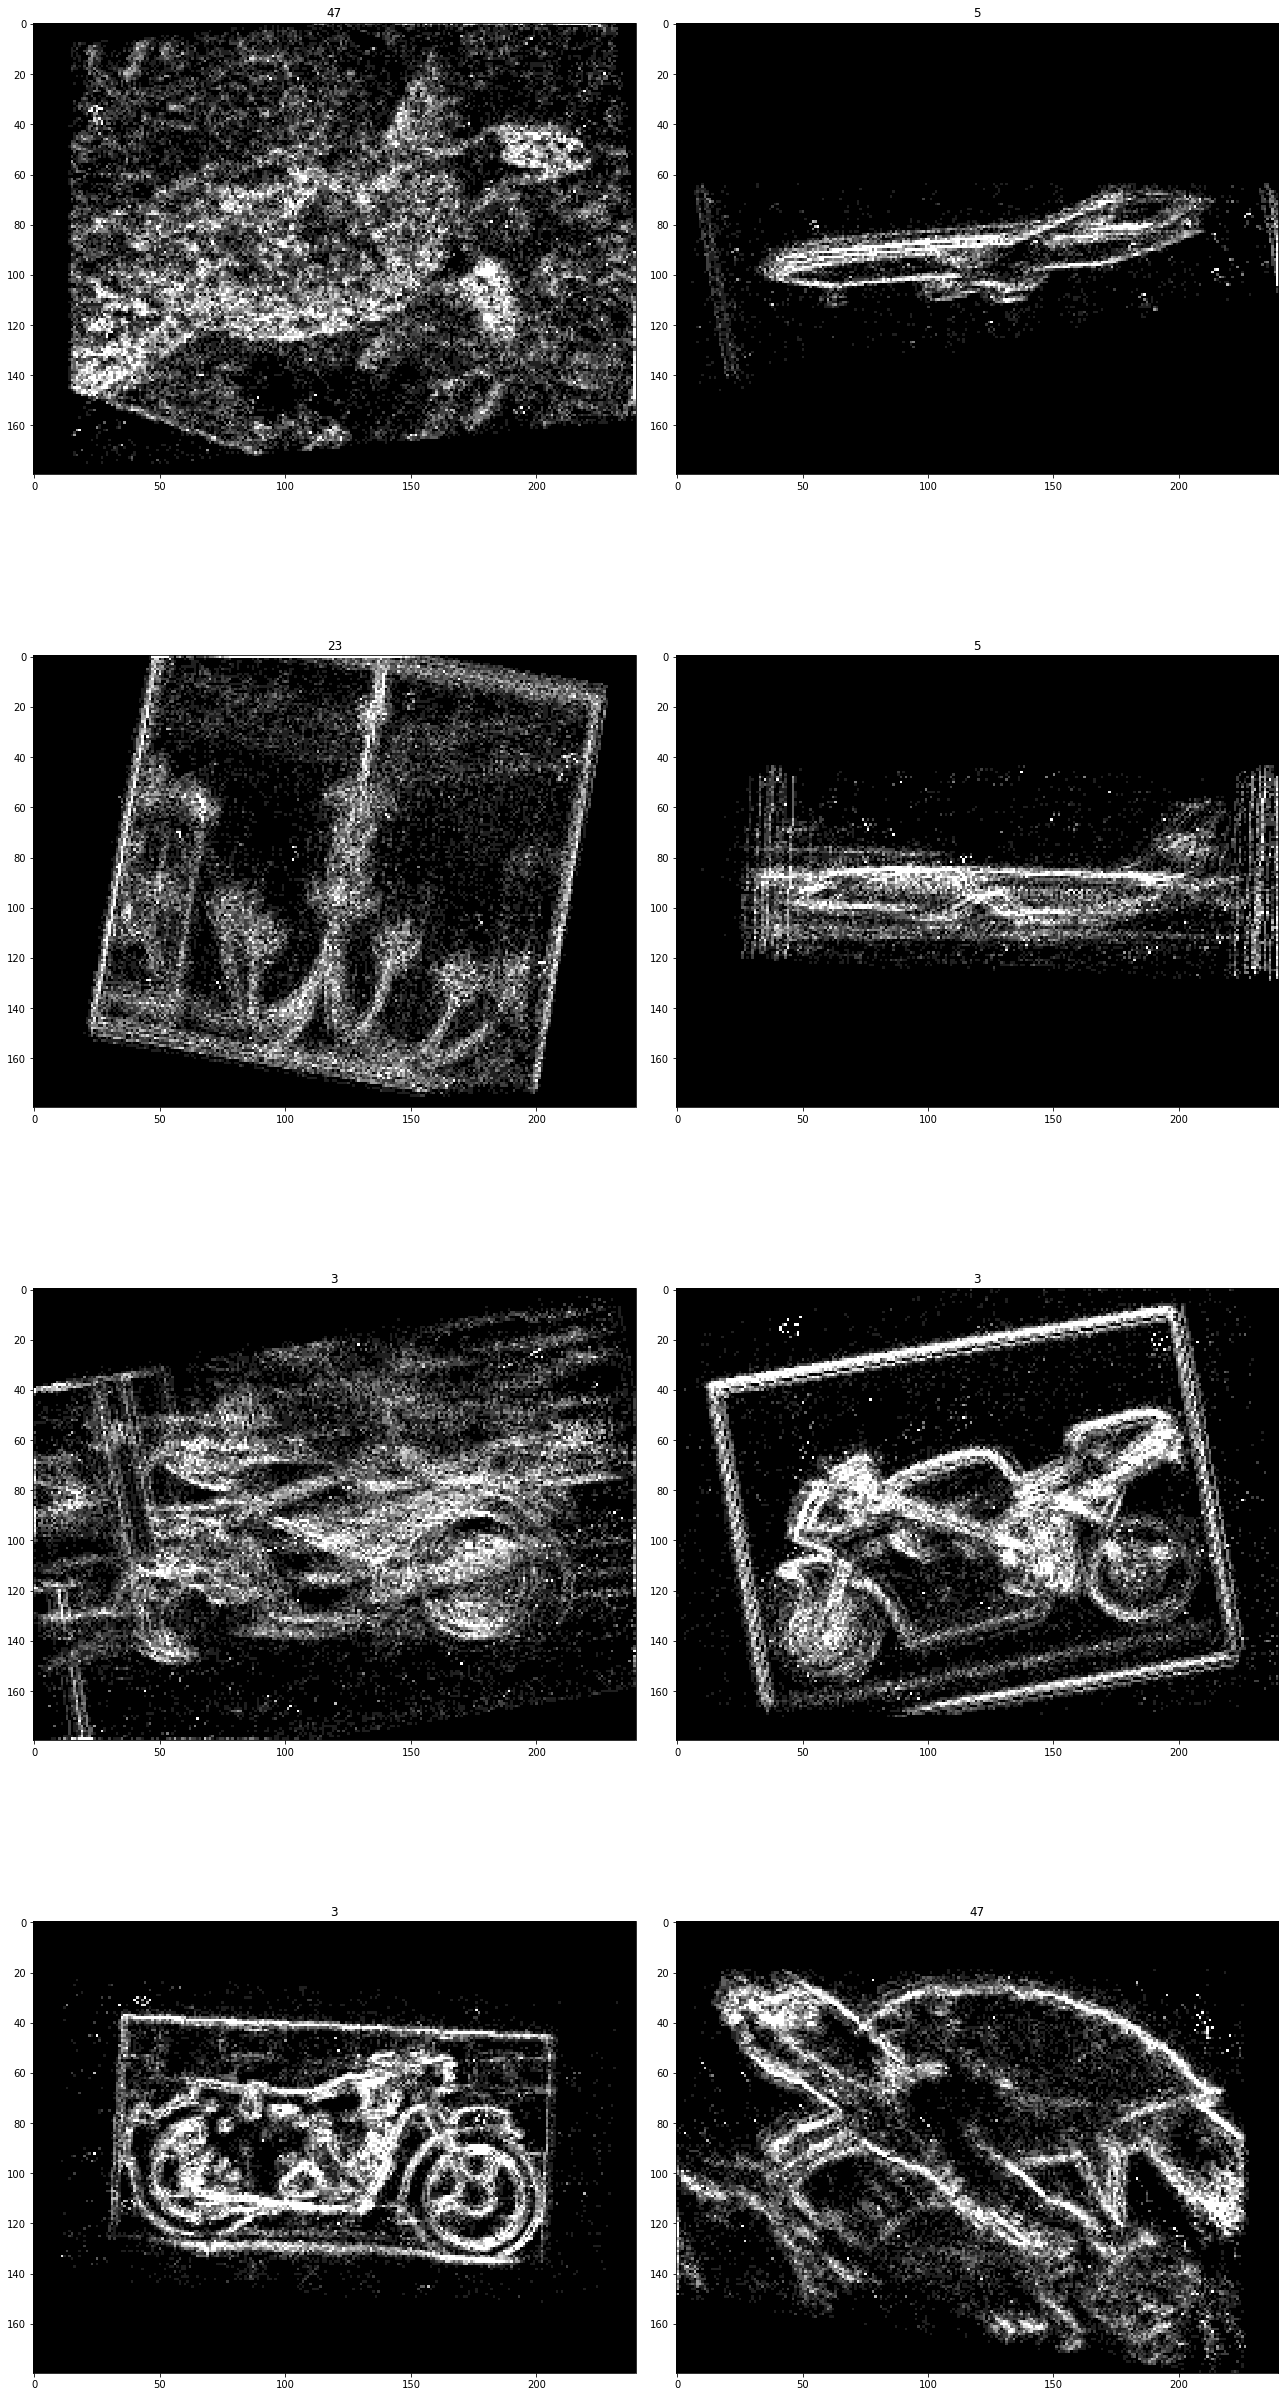

In [ ]:
""" Visualization of training set """
itr = iter(training_loader)
events, labels = next(itr)
preprocessed = model.quantization_layer.forward(events)
preprocessed = preprocessed.cpu().numpy()

print(labels)

fig = plt.figure(figsize=(18, 36))
ax = []
rows = 4
columns = 2
for i in range(rows * columns):
    ax.append( fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title( str( labels[i].item()))
    plt.imshow(preprocessed[i][0], cmap='gray', vmin=0, vmax=8)
plt.tight_layout()
plt.show()

tensor([ 5,  3, 33, 23, 17,  5, 40, 78,  1,  5,  5, 54,  3, 60,  7,  3])


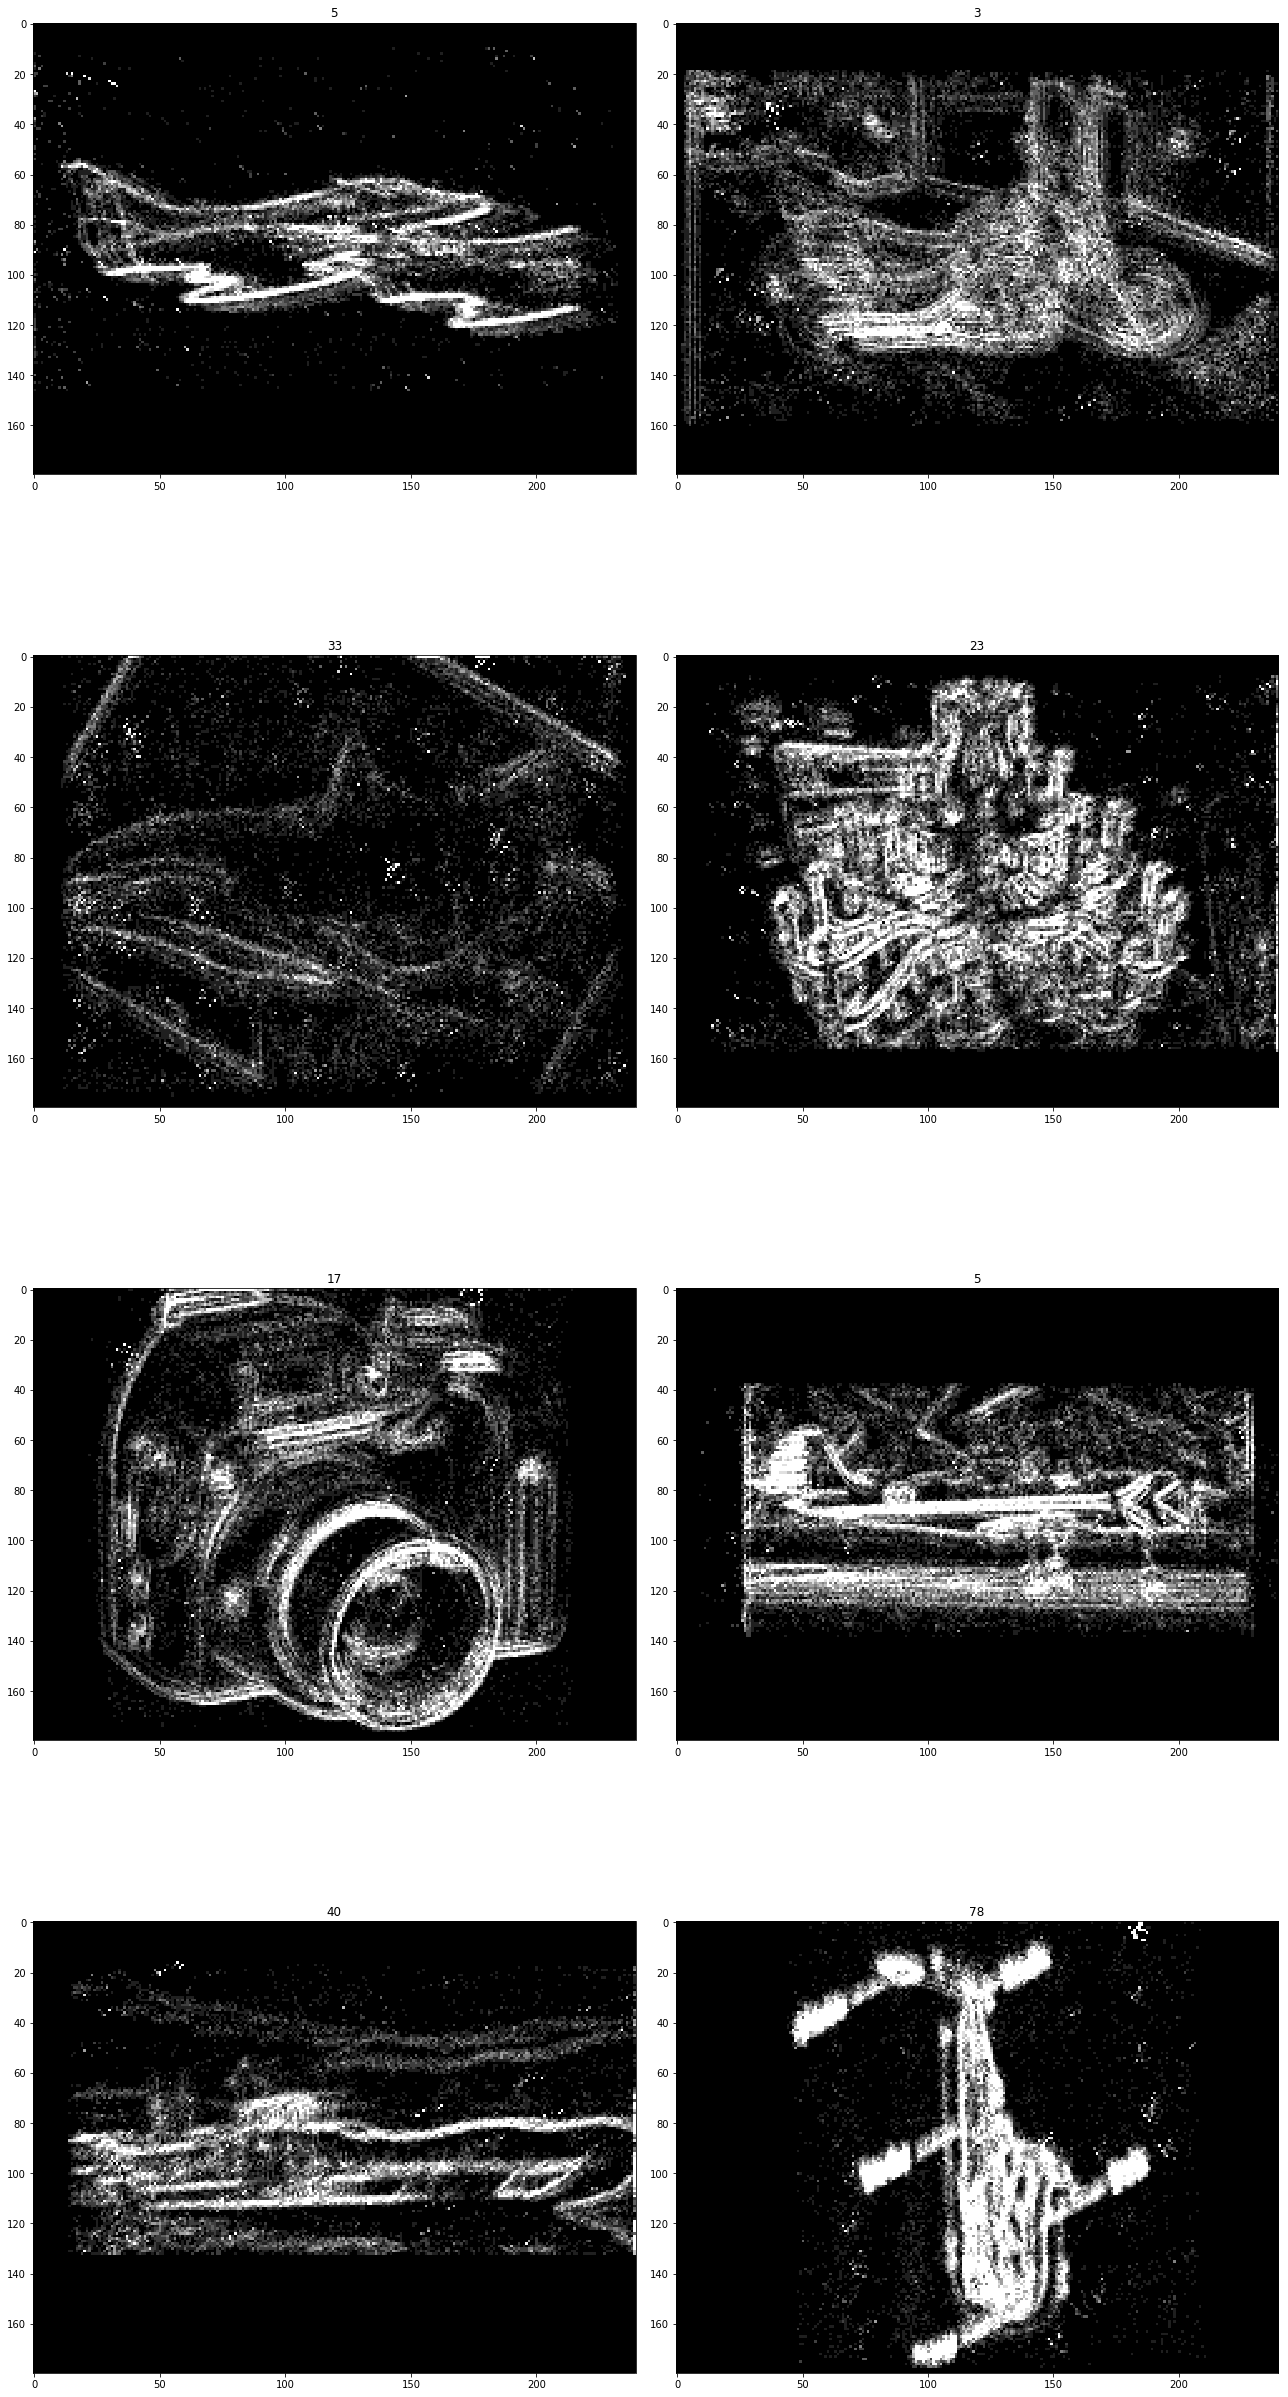

In [ ]:
""" Visualization of validation set """
itr = iter(validation_loader)
events, labels = next(itr)
preprocessed = model.quantization_layer.forward(events)
preprocessed = preprocessed.cpu().numpy()

print(labels)

fig = plt.figure(figsize=(18, 36))
ax = []
rows = 4
columns = 2
for i in range(rows * columns):
    ax.append( fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title( str( labels[i].item()))
    plt.imshow(preprocessed[i][0], cmap='gray', vmin=0, vmax=8)
plt.tight_layout()
plt.show()

In [ ]:
iteration = 0
min_validation_loss = 1000

for i in range(flags.num_epochs):

    print(f"Training step [{i:3d}/{flags.num_epochs:3d}]")
    training_loss, training_accuracy, iteration = train_one_epoch(model, flags.device, optimizer, training_loader, iteration)
    print(f"Training Iteration {iteration:5d}  Loss {training_loss:.4f}  Accuracy {training_accuracy:.4f}")

    if i%10 == 9:
        if optimizerSelect == 'adam':
            lr_scheduler.step()

    if i%1 == 0:
        print(f"Validation step [{i:3d}/{flags.num_epochs:3d}]")
        validation_loss, validation_accuracy = eval_one_epoch(model, flags.device, validation_loader)
        print(f"Validation Loss {validation_loss:.4f}  Accuracy {validation_accuracy:.4f}")

        if validation_loss < min_validation_loss:
            min_validation_loss = validation_loss
            state_dict = model.state_dict()
            torch.save({
                "state_dict": state_dict,
                "min_val_loss": min_validation_loss,
                "iteration": iteration
            }, "log/model_best.pth")
            print("New best at ", validation_loss)
        if i % flags.save_every_n_epochs == 0:
            state_dict = model.state_dict()
            torch.save({
                "state_dict": state_dict,
                "min_val_loss": min_validation_loss,
                "iteration": iteration
            }, "log/checkpoint_%05d_%.4f.pth" % (iteration, min_validation_loss))

Training step [  0/200]


  8%|██████▌                                                                          | 22/273 [02:15<25:55,  6.20s/it]